In [1]:
def split_name(file):
    items = file.split("/")
    new_name = items[-2]+"/"+items[-1]
    return new_name

In [2]:
steerings = []
center = []
left = []
right = []
speed = []
prev_prev = 0
prev = 0
with open("../data/all_log.csv") as f:
    lines = f.read().split("\n")
    print(len(lines))
    for i in range(len(lines)-2):
        line = lines[i+1]
        items = line.split(", ")
        
        steerings.append(0.85*float(items[3])+0.10*prev+0.05*prev_prev)
        prev_prev = prev
        prev = float(items[3])
        center.append(items[0])
        left.append(items[1])
        right.append(items[2])
        speed.append(items[-1])

13405


In [3]:
print("../data/"+center[300])

../data/IMG/center_2016_12_01_13_33_08_649.jpg


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
import json
import h5py

13403 13403 13403 13403


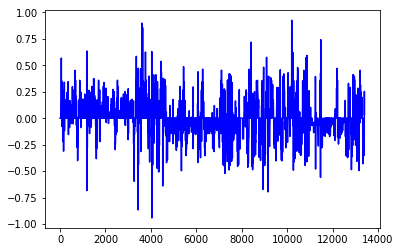

In [4]:
print(len(left),len(right),len(center),len(steerings))
time = range(13403)
plt.plot(time,steerings,  color="blue", linewidth=1.5, linestyle="-")
plt.show()

In [5]:
def camera_adjust(steering, right, speed):
    reaction_time = 2.0
    shift = 20.0 
    # mile/hour to feet/sec
    speed  = speed/3600.0*5280
    adjacent = speed*reaction_time*15.0 
    angle_adj = np.arctan(float(shift)/adjacent)
    if not right:
        angle_adj = - angle_adj
    steering = steering+angle_adj
    return steering

In [6]:
def read_img(img_file, flip):
    img = misc.imread(img_file)
    img_crop = img[55:150,:,:]
    if flip:
        img_crop = cv2.flip(img_crop, 1)
    return img_crop

In [7]:
def change_bright(img):
    image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    change = 0.20+np.random.uniform()*1.3
    image[:,:,2] = image[:,:,2]*change
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

In [8]:
def augment(img,steering, x_range):
    rows,cols,channles = img.shape
#     x_range = 40
    dx = random.choice(range(-x_range,x_range))
    y_range = 12
    dy = random.choice(range(-y_range, y_range))
    d_angle = 0.0040*dx
    new_steering = steering+d_angle
    M = np.float32([[1,0,dx],[0,1,dy]])
    new_img = cv2.warpAffine(img, M, (cols,rows))
#     plt.imshow(new_img)
#     plt.show()
    return new_img, new_steering

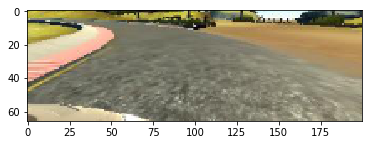

In [9]:
from scipy import misc
img_file = "../data/"+right[7000]
img = read_img(img_file, False)
img = cv2.resize(img, (200, 66))
# img = adjust_gamma(img, 0.5)
# img = change_bright(img)
plt.imshow(img)
plt.show()
# print(steerings[7000])
# # img,ste = augment(img, steerings[7000], 30)
# # img = adjust_gamma(img, 0.5)
# # img = change_bright(img)
# plt.imshow(img)
# plt.show()
# print(ste)

In [10]:
def filter(center, left, right, steerings, threshold):
    delete_list = []
    for i in range(len(center)):
        if steerings[i] < threshold:
            if random.random() < 0.20:
                delete_list.append(i)
    for j in reversed(delete_list):
        del center[j]
        del left[j]
        del right[j]
        del steerings[j]
    return center, left, right, steerings

In [11]:
cen, le, ri, steer = filter(center, left, right, steerings, 0.001)

In [12]:
# print(steer)

In [13]:
def generate_dataset(cen,le,ri,steer):
    dataset = []
    for i in range(len(cen)):
        data = (cen[i],False,steer[i])
        dataset.append(data)
    for i in range(len(le)):
        ste = steer[i]+0.15
        data = (le[i], False, ste)
        dataset.append(data)
    for i in range(len(ri)):
        ste = steer[i]-0.15
        data = (ri[i], False, ste)
        dataset.append(data)
    return dataset

In [14]:
dataset = generate_dataset(cen, le, ri, steer)
print(len(dataset))

34227


In [15]:
def add_flip(dataset):
    new_data = []
    for item in dataset:
        new_data.append((item[0], True, -item[2]))
    dataset.extend(new_data)
    return dataset

In [16]:
dataset = add_flip(dataset)

In [17]:
print(len(dataset))

68454


In [18]:
# adjust brightness
def adjust_gamma(image, gamma=1.0):
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	return cv2.LUT(image, table)

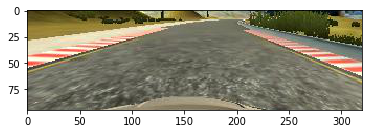

In [19]:
index = 1000
img = read_img("../data/"+dataset[index][0], dataset[index][1])

plt.imshow(img)
plt.show()

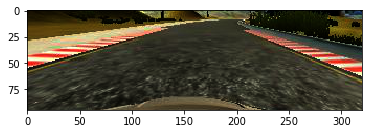

In [20]:
img = adjust_gamma(img, 0.5)
plt.imshow(img)
plt.show()

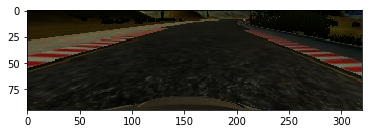

In [21]:
img = change_bright(img)
plt.imshow(img)
plt.show()

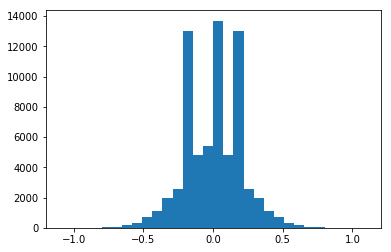

In [22]:
angles = [x[2] for x in dataset]
img,steer = augment(img, dataset[1000][2], 40)
a = plt.hist(angles, 30)
plt.show()

In [32]:
print(np.max(a[0]))

7106.0


In [23]:
index = [x for x in range(len(a[0])) if a[0][x] > 8000]
del_range = [(a[1][index[0]], a[1][index[0]+1]), (a[1][index[1]], a[1][index[1]+1]),(a[1][index[2]], a[1][index[2]+1])]
print(del_range)

[(-0.21844450699999995, -0.14562967133333327), (0.0, 0.072814835666666688), (0.14562967133333338, 0.21844450700000007)]


In [24]:
def filter_mods(dataset, del_range):
    del_list = []
    for i in range(len(dataset)):
        data = dataset[i]
        if (data[2]>del_range[0][0] and data[2]<del_range[0][1]) or (data[2]>del_range[2][0] and data[2]<del_range[2][1]):
            a = random.random()
            if a < 0.60:
                del_list.append(i)
        if (data[2]>del_range[1][0]-0.005 and data[2]<del_range[1][1]-0.005):
            b = random.random()
            if b < 0.50:
                del_list.append(i)
#     print(del_list)
    for j in reversed(del_list):
        del dataset[j]
    return dataset

In [26]:
# new_dataset = filter_mods(dataset, del_range)
# angles = [x[2] for x in new_dataset]
# img,steer = augment(img, new_dataset[1000][2], 40)
# a = plt.hist(angles, 30)
# plt.show()
print(len(new_dataset))

45910


In [27]:
def train_generator(train_dataset, batch_size):
    length = len(train_dataset)
    random.shuffle(train_dataset)
    train_pointer = 0
    while True:
        y_batch = []
        x_batch = []
        while(len(y_batch)<256):
            data = train_dataset[train_pointer%length]
            file = data[0]
            file_path = "../data/"+file
            angle = data[2]
            img = read_img(file_path, data[1])
            if random.random() < 0.85:
                img = change_bright(img)
                if random.random() < 0.5:
                    gamma = random.random()*5+0.2
                    img = adjust_gamma(img, gamma)
#             if angle < 0.05 and angle > -0.02:
#                 if random.random()< 0.15:
#                     continue
            if random.random()<0.1: #0.35
                if random.random() < 0.95:
                    img, angle = augment(img, angle, 10)
                else:
                    img, angle = augment(img, angle, 55)
            img = cv2.resize(img, (200, 66))
            img = img/255.0
            x_batch.append(img)
            y_batch.append(angle)
            train_pointer+=1
        x_batch_out = np.array(x_batch)
        y_batch_out = np.array(y_batch)
        yield x_batch_out, y_batch_out

In [28]:
def valid_generator(valid_dataset, batch_size):
    length = len(valid_dataset)
    random.shuffle(valid_dataset)
    valid_pointer = 0
    while True:
        y_batch = []
        x_batch = []
        while(len(y_batch) < batch_size):
#             if valid_pointer > length:
            data = valid_dataset[valid_pointer%length]
            file = data[0]
            file_path = "../data/"+file
            angle = data[2]
            img = read_img(file_path, data[1])
    #         if angle < 0.07:
    #             if random.random()<0.5:
    #                 continue
#             if random.random()<0.3:
#                 img, angle = augment(img, angle)
            img = cv2.resize(img, (200, 66))
            img = img/255.0
            x_batch.append(img)
            y_batch.append(angle)
            valid_pointer+=1
        x_batch_out = np.array(x_batch)
        y_batch_out = np.array(y_batch)
        yield x_batch_out, y_batch_out

In [29]:
# next(train_gene)

In [27]:
def dataset_split(data_set):
    X_train, X_valid = train_test_split(data_set, test_size = 0.05)
#     X_train, X_valid = train_test_split(X_all_train, test_size = 0.05)
    return X_train, X_valid # , X_test

In [28]:
x_train, x_valid = dataset_split(new_dataset)

In [29]:
print(len(x_train))
# x_train = x_train[0:2560]

43614


In [33]:
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D

from keras.models import Model
from keras.layers import Input, merge
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [34]:
filter_size = [3]
nb_filters = []

In [69]:
def nvidia_model():
    dr = 0.30
    img_input = Input(shape=(66,200,3),name='image')
    conv1 = Convolution2D(3,1,1, border_mode='same',  activation = 'relu',subsample = (1,1),name='color_layer')(img_input)
    
    conv2 = Convolution2D(24,5,5, border_mode='valid', activation = 'relu', subsample = (2,2),name='conv2')(conv1)
#     conv2_drop = Dropout(dr)(conv2)
    conv3 = Convolution2D(36,5,5, border_mode='valid', activation = 'relu',subsample = (2,2),name='conv3')(conv2)
#     conv3_drop = Dropout(dr)(conv3)
    conv4 = Convolution2D(48,5,5, border_mode='valid', activation = 'relu', subsample = (2,2),name='conv4')(conv3)
#     conv4_drop = Dropout(dr)(conv4)
    conv5 = Convolution2D(64,3,3, border_mode='valid', activation = 'relu', subsample = (1,1),name='conv5')(conv4)
#     conv5_drop = Dropout(dr)(conv5)
    conv6 = Convolution2D(64,3,3, border_mode='valid', activation = 'relu', subsample = (1,1),name='conv6')(conv5)
    
    flat = Flatten()(conv6)
    flat_drop = Dropout(dr)(conv6)
    
    fc1 = Dense(100, activation = 'relu')(flat)
    fc1_drop = Dropout(dr)(fc1)
    fc2 = Dense(50, activation = 'relu')(fc1_drop)
    fc2_drop = Dropout(dr)(fc2)
    fc3 = Dense(10, activation = 'relu')(fc2_drop)
    predictions = Dense(1, activation = 'linear')(fc3)
    model = Model(input = [img_input], output=predictions)
    model.summary()
    return model

In [70]:
model = nvidia_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image (InputLayer)               (None, 66, 200, 3)    0                                            
____________________________________________________________________________________________________
color_layer (Convolution2D)      (None, 66, 200, 3)    12          image[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 31, 98, 24)    1824        color_layer[0][0]                
____________________________________________________________________________________________________
conv3 (Convolution2D)            (None, 14, 47, 36)    21636       conv2[0][0]                      
___________________________________________________________________________________________

In [39]:
model.compile(optimizer=Adam(1e-4,decay=5e-5),
              loss='mse')

In [40]:
train_gene = train_generator(x_train,512)
valid_gene = valid_generator(x_valid,512)
per_epoch = len(x_train)/256
checkpoint = ModelCheckpoint('./best_model.hdf5', verbose=1, save_best_only=True)
early = EarlyStopping(monitor='val_loss',patience=2,verbose=1)

In [41]:
# next(train_gene)

In [42]:
history = model.fit_generator(train_gene,samples_per_epoch=len(x_train), nb_epoch=10, verbose=1,
                   validation_data=valid_gene, nb_val_samples=1024,callbacks=[checkpoint, early])

Epoch 1/10
43264/43377 [============================>.] - ETA: 0s - loss: 0.0401  

/home/zhaocheng/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1574: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 0.02572, saving model to ./best_model.hdf5
43520/43377 [==============================] - 87s - loss: 0.0400 - val_loss: 0.0257
Epoch 2/10
43520/43377 [==============================] - 84s - loss: 0.0267 - val_loss: 0.0191
Epoch 3/10
43520/43377 [==============================] - 84s - loss: 0.0230 - val_loss: 0.0155
Epoch 4/10
43520/43377 [==============================] - 84s - loss: 0.0212 - val_loss: 0.0162
Epoch 5/10
43520/43377 [==============================] - 84s - loss: 0.0203 - val_loss: 0.0163
Epoch 6/10
43520/43377 [==============================] - 84s - loss: 0.0194 - val_loss: 0.0136
Epoch 7/10
43520/43377 [==============================] - 84s - loss: 0.0190 - val_loss: 0.0145
Epoch 8/10
43520/43377 [==============================] - 84s - loss: 0.0185 - val_loss: 0.0146
Epoch 9/10
43520/43377 [==============================] - 84s - loss: 0.0181 - val_loss: 0.0130
Epoch 10/10
43520/43377 [==============================] - 84

In [43]:
# model.save_weights("../model.h5")
# with open('model.json','w') as f:
#     f.write(model.to_json())
model.save("../mod_model.h5")

In [52]:
def read_testimg(test_dataset):
    images = []
    angles = []
    for data in test_dataset:
        file = data[0]
        file_path = "../data/"+file
        img = read_img(file_path, data[1])
        img = cv2.resize(img, (200, 66))
        img = img/255.0
        angles.append(data[2])
        images.append(img)
    return np.array(images), np.array(angles)

In [53]:
# print(x_test)

In [54]:
test_x, test_y = read_testimg(x_valid)

In [59]:
model.evaluate(test_x, test_y, batch_size=256)

480/480 [==============================] - 1s     


0.053818313280741374

In [35]:
import json
from keras.models import model_from_json

from keras.models import load_model

# json_file = open("../model.json", 'r')
# loaded_model_json = json_file.read()
# json_file.close()

# model = model_from_json(loaded_model_json)
# del model
model = load_model("../all_model.h5")
# model = nvidia_model()
model.compile(optimizer=Adam(5e-5,decay=3e-4),
              loss='mse')
# weights_file = "../model.h5"
# model.load_weights(weights_file, by_name=Tru

In [36]:
train_gene = train_generator(x_train,512)
valid_gene = valid_generator(x_valid,256)
per_epoch = len(x_train)/256
checkpoint = ModelCheckpoint('./best_model.hdf5', verbose=1, save_best_only=True)
early = EarlyStopping(monitor='val_loss',patience=3,verbose=1)

In [ ]:
history = model.fit_generator(train_gene,samples_per_epoch=len(x_train), nb_epoch=8, verbose=1,
                   validation_data=valid_gene, nb_val_samples=256,callbacks=[checkpoint, early])

Epoch 1/8
3840/3849 [============================>.] - ETA: 0s - loss: 0.0333 

/home/zhaocheng/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1574: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 0.02580, saving model to ./best_model.hdf5
4096/3849 [===============================] - 11s - loss: 0.0331 - val_loss: 0.0258
Epoch 2/8
4096/3849 [===============================] - 9s - loss: 0.0328 - val_loss: 0.0259
Epoch 3/8
3072/3849 [======================>.......] - ETA: 1s - loss: 0.0316

In [39]:
# model  = nvidia_model()
# w1 = model.get_weights()
# model.load_weights('../model.h5')
# w2 = model.get_weights()

# for a,b in zip(w1, w2):
#   if np.all(a == b):
#     print("wtf is happening")

In [40]:
# w1[2]

In [41]:
# w2[25

In [39]:
model.save('../spec_3model.h5')